# Практикум на ЭВМ 317 группы
## Задание 5
### Никишин Евгений Сергеевич

## Всё необходимое

In [1]:
# python 2
from module_for_task5 import *
from __future__ import print_function
%matplotlib inline

## Проверка на адекватность реализованных функций

In [4]:
def check_my_functions():
    check_1 = check_gradient()
    if check_1:
        print('Функция для разностного подсчёта градиента работает корректно')
    else:
        print('Achtung!')
    
    
    # "easy" data
    data = np.random.normal(loc=3, scale=5, size=(5, 12))
    hidden_size = np.array([2, 3, 2])
    visible_size = data.shape[1]

    b_count = np.sum(hidden_size) + visible_size
    theta = initialize(hidden_size, visible_size)
    W, b = theta[:-b_count], theta[-b_count:]

    lambda_ = 0.0001
    sparsity_param = 0.05
    beta = 3
    
    # check backpropagation
    loss, grad = autoencoder_loss(theta, visible_size, hidden_size, 
                                  lambda_, sparsity_param, beta, data)
    J_for_check = lambda x: autoencoder_loss(x, visible_size, hidden_size, 
                                             lambda_, sparsity_param, beta, data)[0]
        
    check_2 = np.allclose(compute_gradient(J_for_check, theta), grad)
    if check_2:
        print('Backpropagation работает корректно')
        print('Максимальное отклонение от разностного градиента ='),
        print(round(np.max(np.abs(compute_gradient(J_for_check, theta) - grad)), 10))
        print('Минимальное по модулю значение градиента ='), 
        print(round(np.min(np.abs(grad)), 5))
    else:
        print('Achtung! Backprop снова сломался')

In [5]:
check_my_functions()

Функция для разностного подсчёта градиента работает корректно
Backpropagation работает корректно
Максимальное отклонение от разностного градиента = 4.02e-08
Минимальное по модулю значение градиента = 0.0817


## Взглянем на нормализацию

In [52]:
with open('./Encoder/27/train.pk') as f:
    data_train = load(f)
with open('./Encoder/27/test.pk') as f:
    data_test = load(f)

In [62]:
data = data_train['X'][:10]
N, D = data.shape
shapes = (N, int(np.sqrt(D/3)), int(np.sqrt(D/3)), 3)
images = data.reshape(shapes)
normalized_images = normalize_data(data)
normalized_images = normalized_images.reshape(shapes)

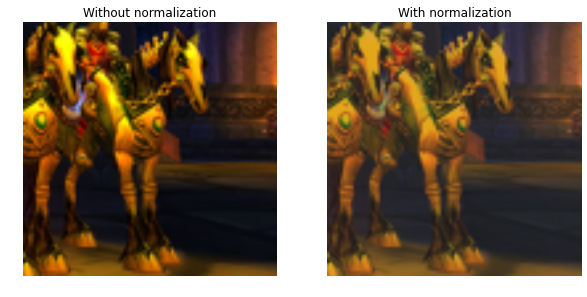

In [63]:
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.title('Without normalization')
plt.imshow(images[3])
plt.axis('off')

plt.subplot(122)
plt.title('With normalization')
plt.imshow(normalized_images[3])
plt.axis('off')

plt.show()

### Как видно, темные участки стали чуть виднее, но самые яркие стали более тусклыми, т.е. были убраны самые яркие и самые темные пиксели (чего мы и хотели)

## Попробуем обучить автокодировщик

### Параметры

In [53]:
data = sample_patches(data_train['X'], num_patches=10000, patch_size=8)
visible_size = data.shape[1]
hidden_size = np.array([75])

b_count = np.sum(hidden_size) + visible_size
theta = initialize(hidden_size, visible_size)
W, b = theta[:-b_count], theta[-b_count:]

lambda_ = 1e-4
sparsity_param = 0.05
beta = 3
options = {'maxiter': 2000,
           'disp': False}

### Обучение

In [54]:
start = time.time()
J = lambda x: autoencoder_loss(x, visible_size, hidden_size, 
                               lambda_, sparsity_param, beta, data)
a = minimize(J, theta, method='L-BFGS-B', jac=True, options=options)
optimal_theta = a['x']
print('Network fitted in', round((time.time() - start) / 60, 1), 'minutes')

Network fitted in 13.5 minutes


## Проверим, что автокодировщик вообще справляется со своей задачей

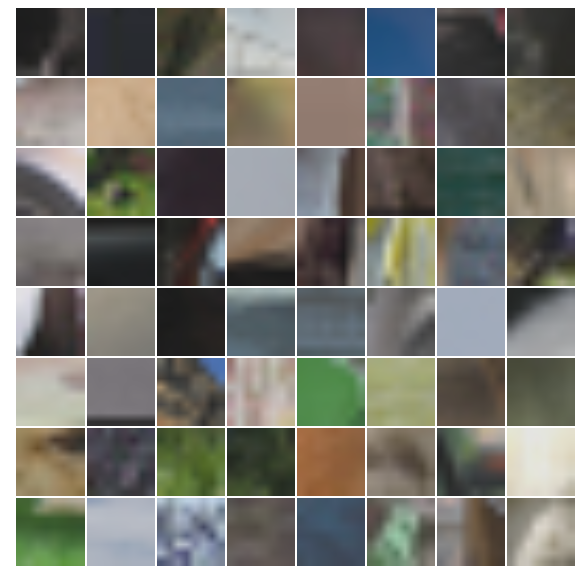

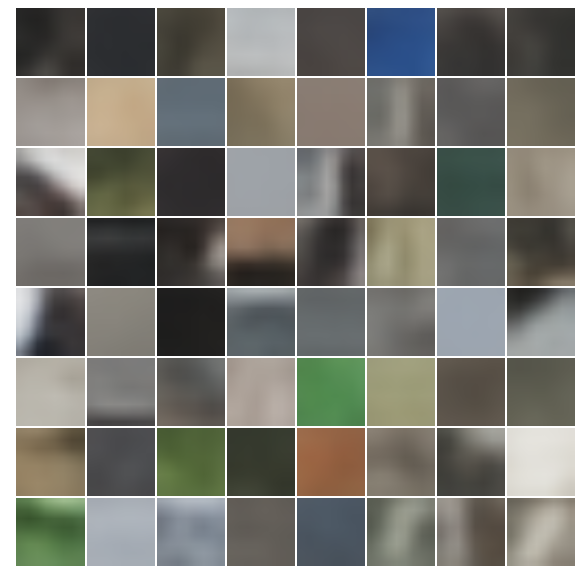

In [55]:
'''
layer_number = 3
activation = autoencoder_transform(optimal_theta, visible_size, 
                                   hidden_size, layer_number, data)
i = 0
display_layer(data[64*i:64*(i+1)])
display_layer(activation[64*i:64*(i+1)])
'''
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.title('Original')
plt.imshow(plt.imread('pics/original.png'))
plt.axis('off')



### Работает!

In [606]:
layer_number = 2

if layer_number > 1:
    size = np.concatenate((np.array([visible_size]), hidden_size, np.array([visible_size])))
    b_count = np.sum(size[1:])
    W, b = optimal_theta[:-b_count], optimal_theta[-b_count:]
    
    W_count = 0
    for i in range(layer_number-1):
        W_needed = W[W_count : W_count + size[i+1]*size[i]].reshape(size[i+1], size[i])
        W_count += size[i+1]*size[i]

display_layer(quick_norm(W_needed))

## Так выглядят эталонные веса (для стандартных параметров) и почти такие же, тоже неплохие для sparsity_param 0.05 (выходят визуально более качественные результаты работы автокодировщика)

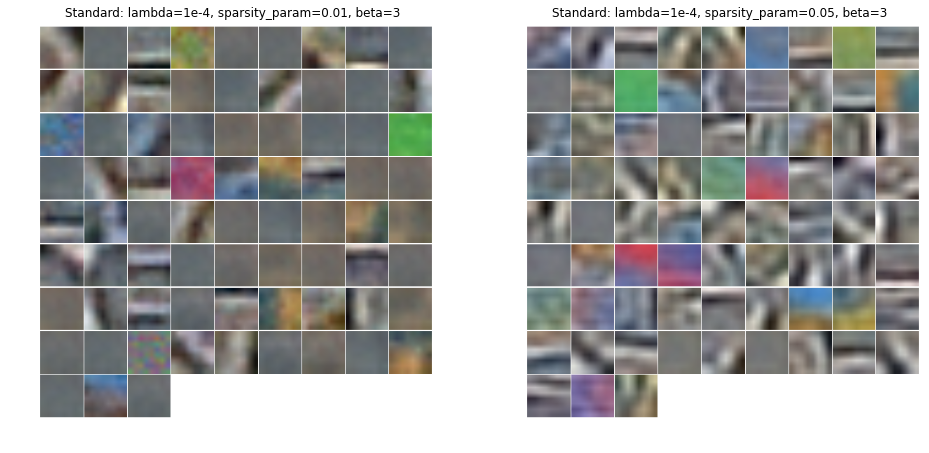

In [57]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('Standard: lambda=1e-4, sparsity_param=0.01, beta=3')
plt.imshow(plt.imread('pics/1_10k_s_0_01_l_1e_4_b_3.png'))
plt.axis('off')

plt.subplot(122)
plt.title('Standard: lambda=1e-4, sparsity_param=0.05, beta=3')
plt.imshow(plt.imread('pics/2_30k_s_0_05_l_1e_4_b_3.png'))
plt.axis('off')

plt.show()

## Зависимость весов от вариации гиперпараметров

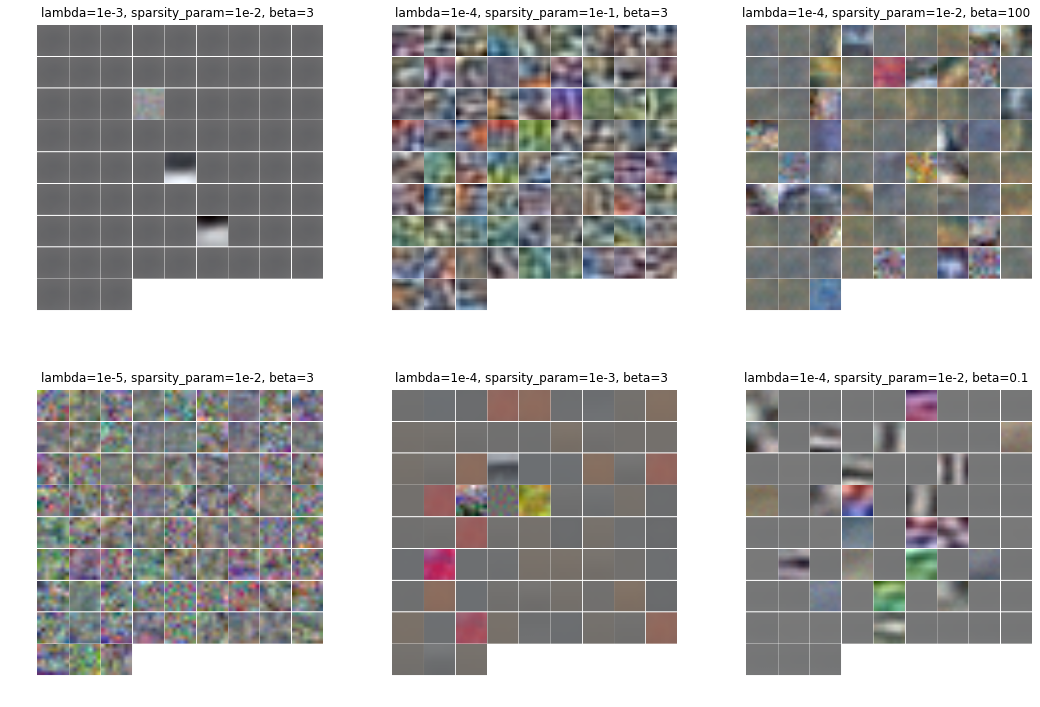

In [415]:
title_list = ['lambda=1e-3, sparsity_param=1e-2, beta=3', 
              'lambda=1e-4, sparsity_param=1e-1, beta=3', 
              'lambda=1e-4, sparsity_param=1e-2, beta=100', 
              'lambda=1e-5, sparsity_param=1e-2, beta=3', 
              'lambda=1e-4, sparsity_param=1e-3, beta=3', 
              'lambda=1e-4, sparsity_param=1e-2, beta=0.1']

files_list = ['pics/10_10k_s_1e_2_l_1e_3_b_3.png',
              'pics/6_10k_s_1e_1_l_1e_4_b_3.png', 
              'pics/5_10k_s_1e_2_l_1e_4_b_100.png', 
              'pics/8_10k_s_1e_2_l_1e_5_b_3.png', 
              'pics/7_10k_s_1e_3_l_1e_4_b_3.png', 
              'pics/4_10k_s_1e_2_l_1e_4_b_0_1.png']

plt.figure(figsize=(18, 12))

for i in range(len(title_list)):
    plt.subplot(2, 3, i+1)
    plt.title(title_list[i])
    plt.imshow(plt.imread(files_list[i]))
    plt.axis('off')

plt.show()

## Кстати, после добавления разреженности произойдут следующие изменения:
### $\delta_i^{(l)} = \biggl(\sum\limits_{j=1}^{s_{l+1}} W_{ji}^{(l)}\delta_j^{(l+1)} + \beta\ (-\frac{\rho}{\hat\rho_i} + \frac{1-\rho}{1-\hat\rho_i})\biggr)\ f'(z_i^{(l)})$

## Попробуем обучить несколько классификаторов просто на интенсивностях пикселей, а затем превзойти результат с помощью автокодировщика

In [2]:
with open('./Encoder/27/train.pk') as f:
    data_train = load(f)
with open('./Encoder/27/test.pk') as f:
    data_test = load(f)
    
y_test = data_test['y'].ravel()
y_train = data_train['y'].ravel()

In [8]:
clf_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_linear = LogisticRegression(solver='sag', n_jobs=-1, max_iter=333)

clf_forest.fit(data_train['X'], y_train)
clf_linear.fit(data_train['X'], y_train)

print('RandomForest accuracy on intensities:', round(accuracy_score(y_test, clf_forest.predict(data_test['X'])), 3))
print('LogisticRegression accuracy on intensities:', round(accuracy_score(y_test, clf_linear.predict(data_test['X'])), 3))

RandomForest accuracy on intensities: 0.413
LogisticRegression accuracy on intensities: 0.326


### Таким образом, цель: на RF больше 0.41, на LR больше 0.32

### Параметры для автокодировщика

In [117]:
layer_number = 2
size = 8
d = int(np.sqrt(data_train['X'].shape[1] / 3))
lambda_ = 1e-4
sparsity_param = 0.03
beta = 3
options = {'maxiter': 2500,
           'disp': False}

### Неразмеченные данные

In [118]:
with open('./Encoder/27/X1.pk') as f:
        unlabeled1 = load(f)
with open('./Encoder/27/X2.pk') as f:
        unlabeled2 = load(f)
# если брать больше, то начинаются проблемы с памятью
unlabeled = np.concatenate((unlabeled1, unlabeled2), axis=0)
%reset_selective -f unlabeled1
%reset_selective -f unlabeled2

In [119]:
num_patches = 3000

unlabeled_patches = sample_patches(unlabeled, num_patches=num_patches, patch_size=size)
visible_size = unlabeled_patches.shape[1]
hidden_size = np.array([75])
#hidden_size = np.array([75, 48, 75])

theta = initialize(hidden_size, visible_size)

### Непосредственно обучение сети

In [120]:
start = time.time()
J = lambda x: autoencoder_loss(x, visible_size, hidden_size, lambda_, sparsity_param, beta, unlabeled_patches)
a = minimize(J, theta, method='L-BFGS-B', jac=True, options=options)
optimal_theta = a['x']
print('Network fitted in', round((time.time() - start) / 60, 1), 'minutes')
%reset_selective -f unlabeled

Network fitted in 1.4 minutes


### Генерация признаков

In [167]:
step = 8
features_count = hidden_size[0] * ((d-size+step) / step) ** 2
#features_count = hidden_size[layer_number-2] * ((d-size+step) / step) ** 2 # для трёхслойной
N = data_train['X'].shape[0]
X_train = np.zeros((N, features_count))

for pic in range(N):
    X_train[pic] = autoencoder_transform(optimal_theta, visible_size, hidden_size, layer_number, 
                                         generate_pics(data_train['X'][pic], size, step)).ravel()

### Обучение классификаторов

In [168]:
clf_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_forest.fit(X_train, y_train)

clf_linear = LogisticRegression(solver='sag', n_jobs=-1, max_iter=333)
clf_linear.fit(X_train, y_train)

%reset_selective -f X_train

### Тестирование

In [169]:
N = data_test['X'].shape[0]
X_test = np.zeros((N, features_count))

for pic in range(N):
    X_test[pic] = autoencoder_transform(optimal_theta, visible_size, hidden_size, layer_number, 
                                        generate_pics(data_test['X'][pic], size, step)).ravel()

print('Random Forest accuracy:', round(accuracy_score(y_test, clf_forest.predict(X_test)), 3))
print('Logistic Regression accuracy:', round(accuracy_score(y_test, clf_linear.predict(X_test)), 3))
%reset_selective -f X_test

Random Forest accuracy: 0.397
Logistic Regression accuracy: 0.485


                                               Зависимость качества от шага
| Шаг | Random Forest | Logistic Regression |
| :-----------:|:-----------:|:-----------:|
| 4 | 0.398 | 0.520 |
| 6 | 0.390 | 0.486 |
| 8 | 0.395 | 0.478 |
| 10 | 0.380 | 0.432 |
| 12 | 0.384 | 0.417 |

##### Однако с шагом 4 время обучения логистической регрессии составляет около 40 минут, учитывая распараллеливание, т.к. количество признаков получается ~100к

## Бонус: зависимость качества классификации от длины выборки при обучении автокодировщика (шаг = 8)

| Размер | Random Forest | Logistic Regression |
| :-----------:|:-----------:|:-----------:|
| 300 | 0.396 | 0.469 |
| 1000 | 0.394 | 0.466 |
| 3000 | 0.395 | 0.478 |
| 10000 | 0.394 | 0.480 |
| 30000 | 0.390 | 0.473 |

## Трёхслойная сеть показала следующие результаты: 0.380 и 0.342 для леса и логистической регрессии соответственно. Интуитивно кажется, что больше слоёв = лучше результат. Поэтому, скорее всего, если аккуратно подобрать параметры и количество нейронов на слоях, можно превзойти результат классификаторов, построенных на основе однослойной сети

## Бонус: ReLU

### Сразу следует отметить, что в нуле функция недифференцируема, поэтому проверка разностной аппроксимацией в нуле недопустима

In [163]:
def check_relu():
    data = np.random.normal(loc=3, scale=5, size=(5, 12))
    hidden_size = np.array([2, 3, 2])
    visible_size = data.shape[1]

    b_count = np.sum(hidden_size) + visible_size
    theta = initialize(hidden_size, visible_size)
    W, b = theta[:-b_count], theta[-b_count:]
    lambda_ = 0.0001
    sparsity_param = 0.05
    beta = 3
    
    # check backpropagation
    loss, grad = autoencoder_loss_relu(theta, visible_size, hidden_size, lambda_, sparsity_param, beta, data)
    J_for_check = lambda x: autoencoder_loss_relu(x, visible_size, hidden_size, lambda_, sparsity_param, beta, data)[0]
    
    return np.isclose(compute_gradient(J_for_check, theta), grad)

In [164]:
check_relu()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False], dtype=bool)

### Что и ожидалось (bias инициализируется нулями)

## Обучим сеть

In [154]:
data = sample_patches(data_train['X'], num_patches=3000, patch_size=8)
visible_size = data.shape[1]
hidden_size = np.array([75])

b_count = np.sum(hidden_size) + visible_size
theta = initialize(hidden_size, visible_size)
W, b = theta[:-b_count], theta[-b_count:]

lambda_ = 1e-4
sparsity_param = 0.05
beta = 3

In [177]:
start = time.time()
J = lambda x: autoencoder_loss(x, visible_size, hidden_size, lambda_, sparsity_param, beta, data)
a = minimize(J, theta, method='L-BFGS-B', jac=True)
optimal_theta = a['x']
print('Network fitted in', round((time.time() - start) / 60, 1), 'minutes')

Network fitted in 16.3 minutes


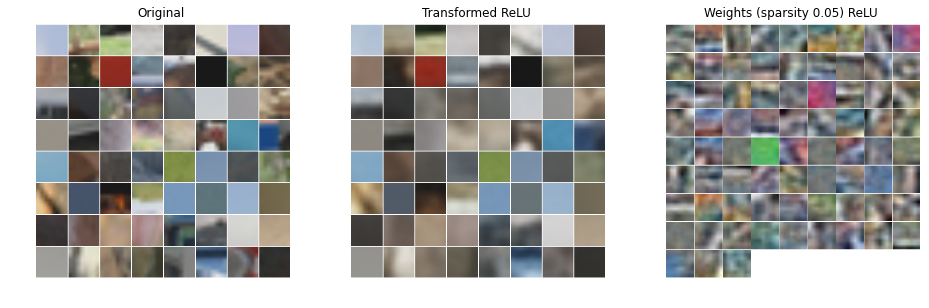

In [176]:
plt.figure(figsize=(16, 6))

plt.subplot(131)
plt.title('Original')
plt.imshow(plt.imread('pics/14_relu_original.png'))
plt.axis('off')

plt.subplot(132)
plt.title('Transformed ReLU')
plt.imshow(plt.imread('pics/15_relu_transformed.png'))
plt.axis('off')

plt.subplot(133)
plt.title('Weights (sparsity 0.05) ReLU')
plt.imshow(plt.imread('pics/16_relu_weights.png'))
plt.axis('off')

plt.show()

### Сложно сравнить качество выхода сети для ReLU и сигмоиды. Примерно одинаково. Да и веса совсем не отличаются. 
### Точности получились 0.397 RF и 0.485 LR. Для тех же параметров классификаторы, построенные на основе сети с сигмоидальной функцией активации, выдали точности 0.395 и 0.478 (несильный прирост,  не исключено также, что имела место случайность, поэтому полагаться на эти данные не стоит)
### Однако заметно ускорение сходимости при минимизации функции потерь: количество итераций при ReLU составляет около 7 тысяч против 10-12 тысяч (если не устанавливать ограничений на количество итераций). Также сигмоиду сложнее считать, чем делать обрезку отрицательной части (а производная вообще есть функция Хевисайда). Поэтому имеет смысл использовать Rectified

# Выводы
### Действительно, границы объектов и цветовые переходы -- хорошие представления для изображений.
### Попытаться объяснить результаты леса и логистической регрессии можно так: при трансформации получаются более осознанные признаки, поэтому наблюдается значительный прирост в качестве LR, но,  в то же время, признаков становится меньше, поэтому наблюдается незначительное ухудшение классификации при использовании RF.
### Из трудностей можно выделить сложность подбора параметров и долгое время обучения сети.